In [1]:
import numpy as np
import pandas as pd
import sklearn
import keras
import random
import collections

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from keras.utils.generic_utils import Progbar

np.random.seed(42)

Using TensorFlow backend.


In [244]:
X = load_digits(n_class=10, return_X_y=False)

In [245]:
X, y = X['images'], X['target']

Target: %d 4


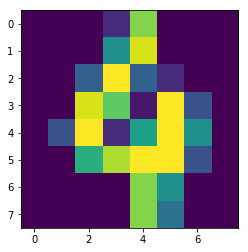

In [246]:
idx = 100
print('Target: %d', y[idx])
plt.imshow(X[idx])

In [247]:
X.shape, y.shape

((1797, 8, 8), (1797,))

In [172]:
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2], 1)

In [248]:
X.shape

(1797, 8, 8)

In [249]:
max_val = np.max(X)
X = X / max_val

In [250]:
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)

In [251]:
y = y.reshape(y.shape[0], y.shape[1], 1)

In [252]:
y.shape

(1797, 10, 1)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [254]:
class Sigmoid:
    @staticmethod
    def fn(z):
        return 1/(1+np.exp(-z))
    @staticmethod
    def prime(z):
        return Sigmoid.fn(z)*(1-Sigmoid.fn(z))
    
class Softmax:
    @staticmethod
    def fn(z):
        return np.nan_to_num(np.exp(z)/np.sum(np.exp(z)))
    @staticmethod
    def prime(z):
        return 1

In [255]:
class QuantifyCost:
    @staticmethod
    def fn(y, a):
        return np.linalg.norm(a-y)**2
    @staticmethod
    def delta(y, a):
        return (a-y)
    @staticmethod
    def loss(y_true, y_pred):
        return 0.5 * (1/len(y_true)) * np.sum([QuantifyCost.fn(y, a) for y, a in zip(y_true, y_pred)])
    
class CrossEntropyCost:
    @staticmethod
    def fn(y, a):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    @staticmethod
    def delta(y, a):
        return (a-y)
    @staticmethod
    def loss(y_true, y_pred):
        return  (1/len(y_true)) * np.sum([CrossEntropyCost.fn(y, a) for y, a in zip(y_true, y_pred)])

In [256]:
class Metrics:
    @staticmethod
    def accuracy(y_true, y_pred):
        eq = np.argmax(y_true, axis=1).squeeze() == np.argmax(y_pred, axis=1).squeeze()
        return list(eq).count(True) / len(y_true)

In [257]:
class WeightsInit:
    @staticmethod
    def zeros(shape):
        return np.zeros(shape)
    @staticmethod
    def randn(shape):
        return np.random.randn(*shape)
    @staticmethod
    def normal(shape):
        return np.random.normal(loc=0.0, scale=(1/np.sqrt(shape[0])), size=shape)

In [258]:
class Dense:
    def __init__(self, shape, winit, binit, fn):
        self.shape = shape
        self.weights = winit((shape[1], shape[0]))
        self.biases = binit((shape[1], 1))
        self.fn = fn
        self.wdelta, self.bdelta = 0, 0
        
    def forward(self, a):
        self.last_input_shape = a.shape
        a = a.reshape(np.product(a.shape), 1)
            
        self.last_input = a
        z = np.dot(self.weights, a) + self.biases
        self.last_z = z
        
        return self.fn.fn(z), z
    
    def backprop(self, d_L_d_out):
        delta = d_L_d_out * self.fn.prime(self.last_z)
        self.bdelta += delta
        self.wdelta += np.dot(delta, self.last_input.T)
        d_L_d_inputs = np.dot(self.weights.T, d_L_d_out)
        return d_L_d_inputs.reshape(self.last_input_shape)
        
    def update(self, eta, lr, batch_size, size, norm):
        self.biases = self.biases - (eta/batch_size) * self.bdelta
        self.weights = self.weights - (eta/batch_size) * self.wdelta
        if norm == 'l2':
            self.weights = self.weights - lr * (eta/size) * self.weights
        elif norm == 'l1':
            self.weights = self.weights - lr * (eta/size) * np.sign(self.weights)
        self.wdelta, self.bdelta = 0, 0


class Model:
    def __init__(self, layers, fcost):
        self.layers = layers
        self.fcost = fcost
        
    def __len__(self):
        return len(self.layers)
        
    def feed_forward(self, a):
        for layer in self.layers:
            a, _ = layer.forward(a)
        return a
    
    def backprop(self, x, y):
        a = x
        for layer in self.layers:
            a, _ = layer.forward(a)
        
        d_L_d_out = self.fcost.delta(y, a)
        for i in range(1, len(self) + 1):
            d_L_d_out = self.layers[-i].backprop(d_L_d_out)
            
        return a
            
    def update_batch(self, X_batch, y_batch, eta, lr, size, norm):
        y_batch_pred = []
        for x, y in zip(X_batch, y_batch):
            y_pred = self.backprop(x, y)
            y_batch_pred.append(y_pred)
            
        for layer in self.layers:
            layer.update(eta, lr, len(y_batch), size, norm)
            
        return y_batch_pred
    
    def evaluate(self, y_true, y_pred, lr, norm):
        loss = self.fcost.loss(y_true, y_pred)
        if norm == 'l2':
            loss += 0.5 * (lr/len(y_true)) * np.sum([np.sum(layer.weights**2) for layer in self.layers])
        elif norm == 'l1':
            loss += (lr/len(y_true)) * np.sum([np.sum(layer.weights) for layer in self.layers])
        acc = Metrics.accuracy(y_true, y_pred)
        return loss, acc
    
    def SGD(self, X_train, y_train, epochs, batch_size, eta, lr=1e-3, validation_data=None, norm=None):
        for epoch in range(epochs):
            y_train_pred = []
            for i in range(0, len(X_train), batch_size):
                y_batch_pred = self.update_batch(X_train[i:i+batch_size], y_train[i:i+batch_size], eta, lr, len(X_train), norm)
                y_train_pred.extend(y_batch_pred)
            
            loss, acc = self.evaluate(y_train, y_train_pred, lr, norm)
            if validation_data:
                X_test, y_test = validation_data
                y_test_pred = [self.feed_forward(x) for x in X_test]
                val_loss, val_acc = self.evaluate(y_test, y_test_pred, lr, norm)
                print('Epoch: %d - val_loss: %0.4f - val_acc: %0.4f' % (epoch, val_loss, val_acc))

In [235]:
deep0 = Dense(shape=(64, 128), winit=WeightsInit.normal, binit=WeightsInit.zeros, fn=Sigmoid)
deep1 = Dense(shape=(128, 10), winit=WeightsInit.normal, binit=WeightsInit.zeros, fn=Sigmoid)
model = Model(layers=[deep0, deep1], fcost=CrossEntropyCost)

model.SGD(X_train, y_train, epochs=100, batch_size=10, eta=1, lr=1e-3, validation_data=(X_test, y_test), norm='l2')

Epoch: 0 - val_loss: 0.9932 - val_acc: 0.9056
Epoch: 1 - val_loss: 0.7058 - val_acc: 0.9306
Epoch: 2 - val_loss: 0.5807 - val_acc: 0.9472
Epoch: 3 - val_loss: 0.5053 - val_acc: 0.9500
Epoch: 4 - val_loss: 0.4534 - val_acc: 0.9556
Epoch: 5 - val_loss: 0.4150 - val_acc: 0.9639
Epoch: 6 - val_loss: 0.3848 - val_acc: 0.9694
Epoch: 7 - val_loss: 0.3604 - val_acc: 0.9639
Epoch: 8 - val_loss: 0.3399 - val_acc: 0.9667
Epoch: 9 - val_loss: 0.3226 - val_acc: 0.9694
Epoch: 10 - val_loss: 0.3078 - val_acc: 0.9694
Epoch: 11 - val_loss: 0.2951 - val_acc: 0.9722
Epoch: 12 - val_loss: 0.2842 - val_acc: 0.9750
Epoch: 13 - val_loss: 0.2747 - val_acc: 0.9750
Epoch: 14 - val_loss: 0.2663 - val_acc: 0.9750
Epoch: 15 - val_loss: 0.2587 - val_acc: 0.9750
Epoch: 16 - val_loss: 0.2520 - val_acc: 0.9750
Epoch: 17 - val_loss: 0.2460 - val_acc: 0.9750
Epoch: 18 - val_loss: 0.2408 - val_acc: 0.9750
Epoch: 19 - val_loss: 0.2362 - val_acc: 0.9778
Epoch: 20 - val_loss: 0.2322 - val_acc: 0.9778
Epoch: 21 - val_loss: 0

In [281]:
class Conv2D:
    def __init__(self, filters, winit, fn):
        self.filters = filters
        self.weights = winit((filters, 3, 3))
        self.fn = fn
        self.wdelta = np.zeros(self.weights.shape)
    
    def iterate_regions(self, a):
        h, w = a.shape
        for i in range(h - 2):
            for j in range(w - 2):
                im_region = a[i:(i + 3), j:(j + 3)]
                yield im_region, i, j
        
    def forward(self, a):
        self.last_input = a
        h, w = a.shape
        output = np.zeros((h - 2, w - 2, self.filters))
        for im_region, i, j in self.iterate_regions(a):
            output[i, j] = np.sum(im_region * self.weights, axis=(1, 2))
        return self.fn.fn(output), output
    
    def backprop(self, d_L_d_out):
        d_L_d_weights = np.zeros(self.weights.shape)
        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.filters):
                d_L_d_weights[f] += d_L_d_out[i, j, f] * im_region
        self.wdelta += d_L_d_weights
    
    def update(self, eta, lr, batch_size, size, norm):
        self.weights = self.weights - (eta/batch_size) * self.wdelta
        if norm == 'l2':
            self.weights = self.weights - lr * (eta/size) * self.weights
        elif norm == 'l1':
            self.weights = self.weights - lr * (eta/size) * np.sign(self.weights)
        self.wdelta = np.zeros(self.weights.shape)
        
class MaxPool2:
    def __init__(self):
        self.weights = 0
        
    def iterate_regions(self, a):
        h, w, _ = a.shape
        new_h = h // 2
        new_w = w // 2
        for i in range(new_h):
            for j in range(new_w):
                im_region = a[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j
                
    def forward(self, a):
        self.last_input = a
        h, w, num_filters = a.shape
        output = np.zeros((h // 2, w // 2, num_filters))
        for im_region, i, j in self.iterate_regions(a):
            output[i, j] = np.amax(im_region, axis=(0, 1))
        return output, output

    def backprop(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)
        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))
            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]
        return d_L_d_input
    
    def update(self, eta, lr, batch_size, size, norm):
        pass

In [282]:
conv2d = Conv2D(filters=3, winit=WeightsInit.normal, fn=Sigmoid)
max_pool = MaxPool2()
dense = Dense(shape=(6*6*3, 10), winit=WeightsInit.normal, binit=WeightsInit.zeros, fn=Sigmoid)
model = Model(layers=[conv2d, dense], fcost=CrossEntropyCost)

model.SGD(X_train, y_train, epochs=100, batch_size=10, eta=3, lr=1e-3, validation_data=(X_test, y_test), norm='l2')

Epoch: 0 - val_loss: 1.6688 - val_acc: 0.7500
Epoch: 1 - val_loss: 1.2567 - val_acc: 0.8944


c:\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Epoch: 2 - val_loss: 1.2798 - val_acc: 0.9111
Epoch: 3 - val_loss: 1.4709 - val_acc: 0.9111
Epoch: 4 - val_loss: 1.7656 - val_acc: 0.9111
Epoch: 5 - val_loss: 2.2396 - val_acc: 0.9194
Epoch: 6 - val_loss: 2.8175 - val_acc: 0.9222
Epoch: 7 - val_loss: 3.5079 - val_acc: 0.9250
Epoch: 8 - val_loss: 4.2746 - val_acc: 0.9306
Epoch: 9 - val_loss: 5.1541 - val_acc: 0.9278


KeyboardInterrupt: 